In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
import re
import string

# Load datasets
true_news = pd.read_csv('data/True.csv')
fake_news = pd.read_csv('data/Fake.csv')

# Add labels
true_news['label'] = 0  # 0 for real news
fake_news['label'] = 1  # 1 for fake news

# Combine datasets
df = pd.concat([true_news, fake_news]).sample(frac=1, random_state=42).reset_index(drop=True)

# Drop unnecessary columns (date, subject might be useful for advanced features, but start simple)
df = df.drop(['subject', 'date'], axis=1)

# Fill any potential NaN values in 'text' or 'title'
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')

# Combine title and text
df['full_text'] = df['title'] + " " + df['text']

print(df.head())
print(df['label'].value_counts())

                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text  label  \
0  Donald Trump s White House is in chaos, and th...      1   
1  Now that Donald Trump is the presumptive GOP n...      1   
2  Mike Pence is a huge homophobe. He supports ex...      1   
3  SAN FRANCISCO (Reuters) - California Attorney ...      0   
4  Twisted reasoning is all that comes from Pelos...      1   

                                           full_text  
0   BREAKING: GOP Chairman Grassley Has Had Enoug...  
1   Failed GOP Candidates Remembered In Hilarious...  
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...  
3  California AG pledges to defend birth control ...  
4  AZ RAN

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Lowercasing
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>+', '', text) # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub(r'\n', '', text) # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers

    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    text = " ".join(tokens)
    return text

df['cleaned_text'] = df['full_text'].apply(preprocess_text)
print(df[['full_text', 'cleaned_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\junu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\junu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                           full_text  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                        cleaned_text  
0  breaking gop chairman grassley enough demands ...  
1  failed gop candidates remembered hilarious moc...  
2  mike pence’s new dc neighbors hilariously trol...  
3  california ag pledges defend birth control ins...  
4  az ranchers living usmexico border destroy nan...  


In [4]:
vectorizer = TfidfVectorizer(max_features=5000) # Limit features for simplicity
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.987750556792873
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4311
           1       0.99      0.99      0.99      4669

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Confusion Matrix:
 [[4270   41]
 [  69 4600]]


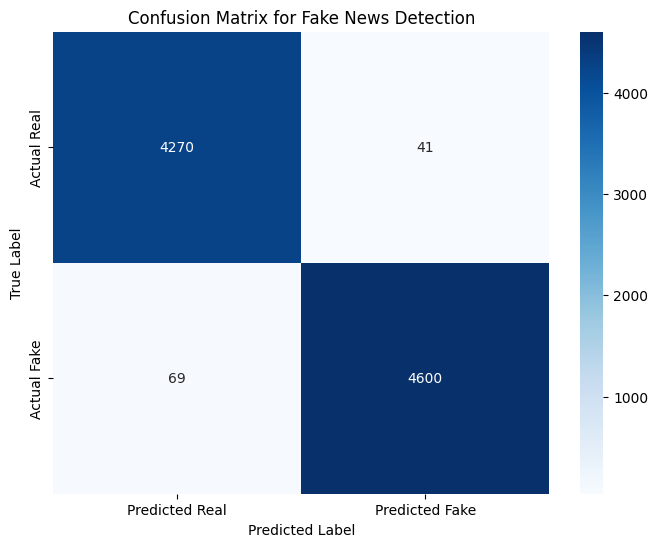

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix for better understanding
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fake News Detection')
plt.show()

In [9]:
import joblib
# Assuming `model` is your trained LogisticRegression and `vectorizer` is your TfidfVectorizer
joblib.dump(model, 'fake_news_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']